<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

# __Embeddings__

Estimated time needed: **35** minutes


You work for a streaming service that wants an automatic way to determine if they should add a movie to its catalog; each film is expensive to purchase, so the  streaming service would only like good movies to add to the catalog. You have been hired to build a neural network to determine if a movie is good or not using critics' written ratings similar to "Rotten Tomatoes". 

In this notebook, you will learn the fundamentals of how to convert text data to usable features for your neural network. In addition, you will also learn about the embedding layer, an engineering solution that allows you to implement linear layers for categorical data effectively. 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/movie_review.webp" style="width: 60%">


## Objectives

After completing this lab, you will be able to:

 - Understand the theory behind Embedding Layers  
 - Apply Tokenizer, Embedding Layers to a neural network 
 - Perform Sentiment Analysis using a neural network 


----


## Setup

For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the corresponding code cell below.


In [ ]:
%%capture
!pip install --upgrade tensorflow

### Importing Required Libraries


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import importlib
import numpy as np

import matplotlib.pyplot as plt
from numpy.random import seed
seed(1)

import  tensorflow as tf

tf.random.set_seed(1234)
from tensorflow.keras.layers import Embedding, Dense, Flatten,Dropout
from tensorflow.keras.models import Sequential

from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import regularizers


2025-05-27 13:19:14.919185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-27 13:19:15.098255: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 13:19:15.104824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-27 13:19:15.104851: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# Print tensorflow version, should be greater than 2.9.0
print(tf.__version__)

2.11.0


### Defining Helper Functions


This function will plot the neural network's loss and accuracy curves from its training history:


In [3]:
def display_metrics(history):

    n = len(history.history["loss"])

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(range(n), (history.history["loss"]),'r', label="Train Loss")
    ax.plot(range(n), (history.history["val_loss"]),'b', label="Validation Loss")
    ax.legend()
    ax.set_title('Loss over iterations')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(n), (history.history["acc"]),'r', label="Train Acc")
    ax.plot(range(n), (history.history["val_acc"]),'b', label="Validation Acc")
    ax.legend(loc='lower right')
    ax.set_title('Accuracy over iterations')

This function will plot word embeddings that have been reduced to two dimensions:


In [4]:
def plot_embedding(X_embedded,start=100,stop=300,sample=10):
    fig, ax = plt.subplots()
    ax.scatter(X_embedded[start:stop:sample,0], X_embedded[start:stop:sample,1])
    for i in range(start,stop,sample):
        ax.annotate(REVERSE_LOOKUP[i+1], (X_embedded[i,0], X_embedded[i,1]))

This function will convert a probability to a Rotten Tomatoes score:


In [5]:
def rotten_tomato_score(p_yx):
    return ["rotten"  if p<=0.60 else "fresh"for p in p_yx ]
        

##  Background


As most machine learning models need their input variables to be numeric, text variables need to be transformed in the pre-processing part. There are several methods to perform this transformation. One-hot and Multi-hot encoding are frequently used to deal with textual data. 

One-hot encoding involves creating a set of vectors whose length equals the number of unique elements in the corpus or the vocabulary. We represent individual words as ones; else, the element is zero. Consider the following list of three **sequences**:


In [6]:
samples=['I hate cats', 
         'the dog is brown and I like cats', 
         'for the']

We have three **sequences**, and the corresponding number of **word tokens** for each sequence is given by:


1. I hate cats - 3 tokens 

2. the dog is brown and likes cats - 8 tokens

3. for the - 2 tokens




### Tokenizer


One way to encode text features to numeric features is using <b>one-hot-encoding</b> or <b>multi-hot-encoding</b>. The one-hot and multi-hot-encoding vector is a vector consisting of all zeros; if the sequence of text contains a specific word, then an element of the vector is set to one. Consider the vocabulary that consists of all the words in the list ```samples``` each vector will have an element assigned to it shown here:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/one_hot.png" width="200" height="250">


Keras has an additional component for words not in the vocabulary that we will leave out in this explanation. We have ten words; therefore, the vector will have ten elements. For example, we have the vector for the word ```I``` given by:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/I.png" width="550" height="650">


All the elements in the vector are zero except for the index corresponding to the word ```I```; this is an example of one-hot-encoding. For **multi-hot-encoding** the sentence 'I hate cats', the vector is given by the following:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/I_hate_cats.png" width="550" height="650">


We can also represent the sequence as three one-hot-encoding vectors. We see that for each word that occurs, the value in the vector is set to one; else, they are set to zero; the dimension of both encoding vectors is equal to the number of unique words in the corpus (vocabulary). 

Lets see how to convert a sequence of multi-hot-encoding vectors.


###  Embedding

An embedding layer in Keras can be used when we want to create the embedding. These embeddings are learnable parameters that embed high dimensional data into lower dimensional vectors. Lets assume we have the embedding for the vocabulary above, we can represent the vocabulary as a list of parameter vectors $[w_{I}, w_{cats}, w_{the}, w_{hate}, w_{dog}, w_{is}, w_{brown},w_{and}, w_{like }, w_{for} ] $ .   

Thus, we can obtain the embedding for the sentence **"I hate cats"** by first performing one-hot-encoding for each token (as shown on the right) and then performing the matrix multiplication with the parameter vectors on the left: 

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/Ihat_cats_embeding.png" width="1000" height="1200">


We represent the matrix as a set of three **one-hot-encoded** column vectors. We see the resultant vector is 1x3 **(output dimension x input length)** as Keras transposes this result. The input length is the number of words in a sentence. In this case, the output dimension is one, but it is usually a free parameter that you set as the number of dimensions of the low-dimensional space. 

We see that the operation is wasteful as we are multiplying many vectors by zeros. In real world applications, the one-hot-encoding is thousands of dimensions long. As a result, we use an **embedding layer**; this layer simply **outputs the parameters given the indexes**, as shown below. We can use these embeddings as the input to a neural network. Note that the parameters of an embedding layer are randomly initialized and are updated when training the neural network, just like the fully connected layers:


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module4/L1/I_hate_cats_embeding.png" width="1000" height="1200">


## Tokenizer in Keras


Keras has the class ``Tokenizer`` that allows you to vectorize a text by turning each word into either a sequence of integers or a vector where the coefficient for each token is binary, based on word count. We will use the following parameters:

```num_words```: the maximum number of words to keep in a sentence, based on the highest word frequencies, that is, only the **most common** ``num_words`` words will be kept.

```filters```: a string that contains characters that will be filtered from the texts. The default is all the punctuations, tabs, line breaks, and the ' character.

```lower```: boolean type, indicates whether to convert the texts to lowercase.

```split```: str, indicates the separator for word splitting.

We create the ```Tokenizer``` object:


In [7]:
tokenizer = Tokenizer(num_words=11)

To fit the tokenizer to our text data, we call the method ```fit_on_texts```. The layer will build a corpus (vocabulary) of all string tokens obtained from the samples, and each word in the vocabulary will be represented by an integer or a vector.


In [8]:
tokenizer.fit_on_texts(samples) 

The attribute ```word_counts``` is a list of words, tokens, and the corresponding number of times they appeared in the samples:


In [9]:
word_counts=tokenizer.word_counts
word_counts

OrderedDict([('i', 2),
             ('hate', 1),
             ('cats', 2),
             ('the', 2),
             ('dog', 1),
             ('is', 1),
             ('brown', 1),
             ('and', 1),
             ('like', 1),
             ('for', 1)])

We can use the method ```texts_to_matrix``` to perform multi-hot encoding, where each element of the resultant vector is set to one if the corresponding word exists in the sequence; else, the element is set to zero. Here we perform multi-hot encoding for each word in the different sequences:


In [10]:
for key in tokenizer.word_counts.keys():
    
    print(key)
    print(tokenizer.texts_to_matrix([key]))

i
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
hate
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
cats
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
the
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
dog
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
is
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
brown
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
and
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
like
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
for
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


As there is a total of ten words in the sequence, the vector has ten elements; each element in the vector corresponds to a different word. 


In [11]:
for sample  in samples:
    
    print(sample)
    print(tokenizer.texts_to_matrix([sample]))

I hate cats
[[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]
the dog is brown and I like cats
[[0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]]
for the
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]


We can also apply different NLP transformations using the parameter ```mode```.


In [12]:
modes=[ "binary", "count", "tfidf", "freq"]
for mode in modes: 
    print("mode:",mode)
    for sample  in samples:
        
        print(sample)
        print(tokenizer.texts_to_matrix([sample],mode=mode))

mode: binary
I hate cats
[[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]
the dog is brown and I like cats
[[0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]]
for the
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]
mode: count
I hate cats
[[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]]
the dog is brown and I like cats
[[0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]]
for the
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]
mode: tfidf
I hate cats
[[0.         0.69314718 0.69314718 0.         0.91629073 0.
  0.         0.         0.         0.         0.        ]]
the dog is brown and I like cats
[[0.         0.69314718 0.69314718 0.69314718 0.         0.91629073
  0.91629073 0.91629073 0.91629073 0.91629073 0.        ]]
for the
[[0.         0.         0.         0.69314718 0.         0.
  0.         0.         0.         0.         0.91629073]]
mode: freq
I hate cats
[[0.         0.33333333 0.33333333 0.         0.33333333 0.
  0.         0.         0.         0.         0.        ]]
the dog is brown and I like cats
[[0.    0.125 0.125 0.125 0.    0.125 0.12

In many cases, Multi-hot encoding is redundant. As a result, we use the method ```texts_to_sequences```. This method will output an integer sequence where each integer corresponds to the index of the element in the corpus. The sequence length is equal to the number of words or tokens in the input sequence, as opposed to the number of words in the entire vocabulary like in Multi-hot encoding.


In [13]:
for sample  in samples:
    
    print(sample)
    print(tokenizer.texts_to_sequences([sample]))

I hate cats
[[1, 4, 2]]
the dog is brown and I like cats
[[3, 5, 6, 7, 8, 1, 9, 2]]
for the
[[10, 3]]






### Input Dimension 


Let's look at an example where we want to output the integer **input_dim**, which is the size of the vocabulary or maximum integer index.


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input

import numpy as np


model = Sequential()

input_dim=3
output_dim=1
input_length=1
model.add(Embedding(input_dim=input_dim, output_dim=output_dim,input_length=input_length))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 1)              3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


2025-05-27 13:32:33.498546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-27 13:32:33.498608: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-27 13:32:33.498632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterlab-hybraid6): /proc/driver/nvidia/version does not exist
2025-05-27 13:32:33.499051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras randomly initialize the weights, so let's set each weight to the index it belongs to:


In [15]:
model.get_weights()
weights=np.array([0,1,2]).reshape(-1,1)

model.set_weights([weights])
model.get_weights()

[array([[0.],
        [1.],
        [2.]], dtype=float32)]

We can apply the function to each integer. The embedding layer will return the parameter value(s) or vector(s) on the position(s) which have the index value(s) equal to the integer(s) in the sequence.


In [16]:
for n in range(3):
    x=np.array([[n]])
    print("input x={}".format(n))
    z=model.predict(x)
    print("output z={}".format(z.tolist()))

input x=0
1/1 [==============================] - 0s 116ms/step
output z=[[[0.0]]]
input x=1
1/1 [==============================] - 0s 28ms/step
output z=[[[1.0]]]
input x=2
1/1 [==============================] - 0s 20ms/step
output z=[[[2.0]]]


We can also apply the method to multiple samples, by making each sample a different sample in the batch dimension or as multiple samples in a row:


In [18]:
z = model.predict([[0],[1],[2]])
print("different samples in the batch dimension:\n",z)
z = model.predict([0,1,2])
print(" multiple samples in a row: \n",z)

1/1 [==============================] - 0s 39ms/step
different samples in the batch dimension:
 [[[0.]]

 [[1.]]

 [[2.]]]
1/1 [==============================] - 0s 35ms/step
 multiple samples in a row: 
 [[0.]
 [1.]
 [2.]]


If you use the ```Sequential``` class, you must specify the input shape ```input_length``` so the model can be built with the proper set of parameters; ```input_length``` is the size of each input sequence.


### Output shape

Output shape is the number of parameters, using the matrix multiplication analogy: if the input is a multi-hot encoding column vector and the embedding is a matrix, the ```output_dim``` is the number of columns in the matrix. Consider the example of converting a number to its binary number equivalent, and we will represent each element of the binary number as a different dimension in the output. 

Let's convert the numbers from 0 to 3. As we have four numbers the parameter ```input_dim=4```. As we need two binary digits or bits to represent the numbers from one to three the ```output_dim=2```.


In [19]:
input_dim=4
output_dim=2
input_length=1
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 2)              8         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


We assign the ```weights``` to represent binary numbers;


In [20]:
weights=np.array([[0,0],[0,1],[1,0],[1,1]])
model.set_weights([weights])
model.get_weights()

[array([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]], dtype=float32)]

For each input integer, the output of the embedding is the corresponding binary number:


In [21]:
for n in range(4):
    x=np.array([[n]])
    print("input x={}".format(n))
    z=model.predict(x)
    print("input binary={}".format(z.tolist() ))

input x=0
1/1 [==============================] - 0s 38ms/step
input binary=[[[0.0, 0.0]]]
input x=1
1/1 [==============================] - 0s 20ms/step
input binary=[[[0.0, 1.0]]]
input x=2
1/1 [==============================] - 0s 19ms/step
input binary=[[[1.0, 0.0]]]
input x=3
1/1 [==============================] - 0s 19ms/step
input binary=[[[1.0, 1.0]]]


in order to use the embedding, we go with seqeuntial 


### Padding Sequences


Usually, sequences are of different lengths. Consider our original sequence:


In [22]:
samples=['I hate cats','the dog is brown and I like cats','for the']
for sample in samples:
    print("sample:",sample)
    print("length:",len(sample))

sample: I hate cats
length: 11
sample: the dog is brown and I like cats
length: 32
sample: for the
length: 7


When we apply the ```Tokenizer``` we apply the method ```texts_to_sequences``` we see each sequence is also a different length:


In [23]:
tokenizer = Tokenizer(num_words=12)
tokenizer.fit_on_texts(samples) 
tokens=tokenizer.texts_to_sequences(samples)
print("tokens",tokens)

tokens [[1, 4, 2], [3, 5, 6, 7, 8, 1, 9, 2], [10, 3]]


To make sure the sequences are the same length, we apply the function ```pad_sequences```. The function transforms a sequence into a 2D Numpy array with the number of rows equal to the number of samples and the number of columns equal to the parameter ```maxlen``` (the length of the longest sequence in the list). Sequences that are shorter than ```maxlen``` are padded with the parameter ```value```, which is by default zero. 

Consider the following example:


In [24]:
maxlen=9
x =pad_sequences(tokens, maxlen=maxlen,value=0)
x

array([[ 0,  0,  0,  0,  0,  0,  1,  4,  2],
       [ 0,  3,  5,  6,  7,  8,  1,  9,  2],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  3]], dtype=int32)

We see the padding proceeds the integer values, but we can also set padding to follow the integers through ```padding = "post"```.


In [25]:
maxlen=9
x =pad_sequences(tokens, maxlen=maxlen,padding="post")
x

array([[ 1,  4,  2,  0,  0,  0,  0,  0,  0],
       [ 3,  5,  6,  7,  8,  1,  9,  2,  0],
       [10,  3,  0,  0,  0,  0,  0,  0,  0]], dtype=int32)

If we decrease the value for ```maxlen```, the function will ```truncate``` the sequences, that is, making sequences that are longer than `maxlen` shorter.


In [26]:
maxlen=5
x =pad_sequences(tokens, maxlen=maxlen)
x

array([[ 0,  0,  1,  4,  2],
       [ 7,  8,  1,  9,  2],
       [ 0,  0,  0, 10,  3]], dtype=int32)

We see the function truncates the values from sequences longer than ```maxlen``` at the beginning of the sequence. We can also set ```truncating = "post"```to  truncate the values from the end.


## Sentiment Analysis 


Now that we have the sequence, , and embedding layers, we can use a neural network to classify our text data. Sentiment analysis in natural language processing is a technique used to determine opinions, appraisals, emotions, or attitudes towards a topic, person, or entity. 

Consider the IMDB dataset of 25,000 movie reviews from IMDB, labeled positive (y=0) and negative (y=1). In this dateset, the reviews have been pre-processed, and each review is encoded as a list of word indexes (integers). The words are indexed by overall frequency in the dataset so that for instance, the integer "3" encodes the 3rd most frequent word in the data. We will "only consider the top 10,000 most common words, but eliminate the top 20 most common words for more on the dataset check out <a href="https://keras.io/api/datasets/imdb/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">here </a>. We download the dataset:


In [27]:
from keras.datasets import imdb

In [28]:
max_features = 10000

# change the default parameter of np to allow_pickle=True
np.load.__defaults__=(None, True, True, 'ASCII')
importlib.reload(np)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features )

17464789/17464789 [==============================] - 0s 0us/step


We print out the first three samples and we see the dataset has been tokenized: 


In [29]:
for i,x in enumerate(x_train[0:3]):
    print("Sequence:",i) 
    print(x)

Sequence: 0
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
Sequence: 1
[1, 194, 1153, 194, 8255, 78, 228, 5

We can obtain a dictionary look-up table with the word and the integer that represents it:


In [30]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


We invert the table so the key is the integer that represents the word, and the value is the word. We assign the new dictionary to the variable ```REVERSE_LOOKUP```:


In [31]:
REVERSE_LOOKUP={value:key for key, value in word_index.items()}

The following function will use ```REVERSE_LOOKUP``` to convert an input sequence x to the original review. 


In [32]:
def get_review(x):
     return' '.join([REVERSE_LOOKUP[index ] for index in x])

We can obtain the review for the first sample:


In [34]:
get_review(x_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have t

Similarly, we obtain the review for the second sample:


In [35]:
get_review(x_train[1])

"the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch and of solid it thought begins br senator and budget worthwhile though ok and awaiting for ever better were and diverse for budget look kicked any to of making it out and follows for effects show to show cast this family us scenes more it severe making senator to and finds tv tend to of emerged these thing wants but and an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them"

Each sample is of a different length; for example, we can print the length of the first three samples:


In [36]:
for i,x in enumerate(x_train[0:3]):
    print("length {} of sample {}:".format(i,len(x)))


length 0 of sample 218:
length 1 of sample 189:
length 2 of sample 141:


As a result, we need to pad all the sequences using ```pad_sequences```:


In [37]:
maxlen=20
x_train =pad_sequences(x_train, maxlen=maxlen)
x_test =pad_sequences(x_test, maxlen=maxlen)


In [38]:
x_test.shape

(25000, 20)

Now we can create the embedding layer. We know the number of words is ```max_features=10000``` and therefore ```input_dim=10000```. The dimension of the output is a parameter that we set. Let's set ```output_dim=8``` and ```input_length=1``` for now.

We also need to add a flattening layer using ```Flatten()```, which adds an extra dimension and will reshape the input as ```(batch, 1)```.


In [39]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=20))
model.add(Flatten())


We can now add a fully connected layer with `units=1` for classification:


In [40]:
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


Let's fit the model:


In [41]:
history = model.fit(x_train, y_train, epochs=10,batch_size=30,validation_split=0.2)

Epoch 1/10
667/667 [==============================] - 4s 5ms/step - loss: 0.6652 - acc: 0.6281 - val_loss: 0.6073 - val_acc: 0.6998
Epoch 2/10
667/667 [==============================] - 3s 4ms/step - loss: 0.5332 - acc: 0.7512 - val_loss: 0.5180 - val_acc: 0.7352
Epoch 3/10
667/667 [==============================] - 3s 4ms/step - loss: 0.4590 - acc: 0.7892 - val_loss: 0.4977 - val_acc: 0.7522
Epoch 4/10
667/667 [==============================] - 2s 4ms/step - loss: 0.4229 - acc: 0.8093 - val_loss: 0.4950 - val_acc: 0.7564
Epoch 5/10
667/667 [==============================] - 3s 4ms/step - loss: 0.3985 - acc: 0.8218 - val_loss: 0.4955 - val_acc: 0.7582
Epoch 6/10
667/667 [==============================] - 3s 4ms/step - loss: 0.3775 - acc: 0.8335 - val_loss: 0.4992 - val_acc: 0.7560
Epoch 7/10
667/667 [==============================] - 3s 4ms/step - loss: 0.3590 - acc: 0.8451 - val_loss: 0.5029 - val_acc: 0.7530
Epoch 8/10
667/667 [==============================] - 3s 4ms/step - loss: 0.

We can plot the training history:


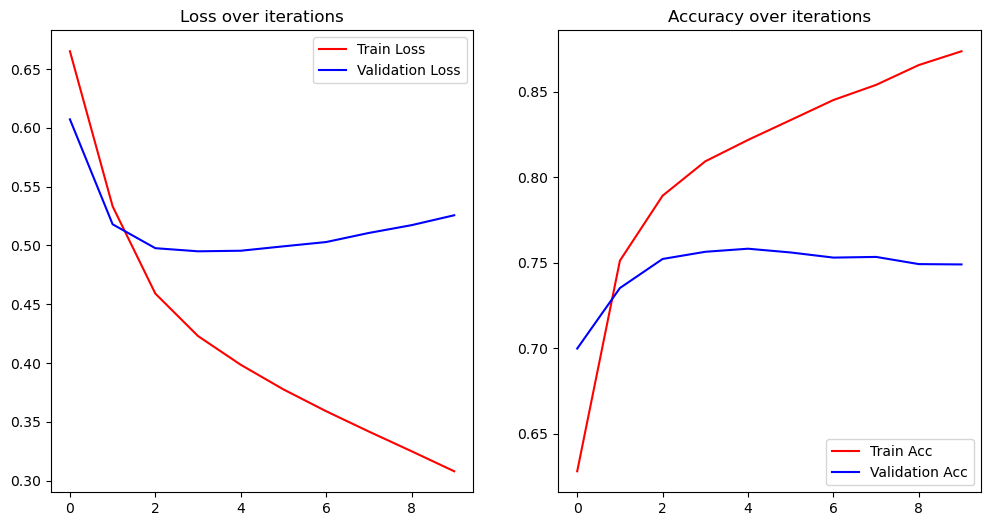

In [42]:
display_metrics(history)

The output of the model is a probability as it ranges from 0 to 1, so we can use this as a proxy for the Rotten Tomatoes score:


In [43]:
p_yx=model.predict(x_test[0:10])

1/1 [==============================] - 0s 63ms/step


We can obtain the the rating using the helper function ```rotten_tomato_score``` which maps a probability to a prediction:


In [44]:
rotten_tomato_score(p_yx)

['rotten',
 'fresh',
 'rotten',
 'fresh',
 'fresh',
 'rotten',
 'fresh',
 'rotten',
 'rotten',
 'fresh']

### Visualizing the embedding  weights


The weights in the embedding layer contain correlations between words. Let's obtain the embedding weights:


In [45]:
weights=model.layers[0].get_weights()[0]

There are 10,000 words so there are 10,000 different parameter vectors, each has 8 dimensions:


In [46]:
weights.shape

(10000, 8)

We can't visualize the vector as it's 8-dimensional, but we can use **T-distributed Stochastic Neighbor Embedding (TSNE)** to reduce the dimension to two for visualizing the embeddings on a 2D plot:


In [47]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(weights)

Now that the embeddings are transformed let's use the helper function ```plot_embedding``` to visualize them. The starting word index is ```start```, and ```stop``` is the index of the last word; ```sample``` is the number of samples between samples.


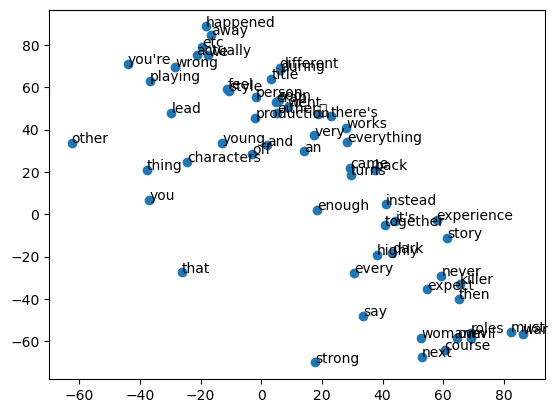

In [48]:
start=1
stop=600
sample=10
plot_embedding(X_embedded,start,stop,sample)


We see words like "war", "evil", and "killer" are clustered in the lower-right quadrant.


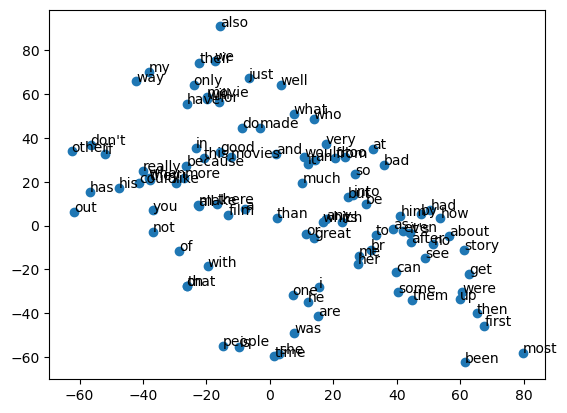

In [49]:
start=1
stop=100
sample=1
plot_embedding(X_embedded,start,stop,sample)

### Exercise 1 

Recreate the model above but add a dense layer with 500 neurons (using relu activation), a dense layer with 250 neurons (using relu activation), and a final layer for classification, then use the function ```display_metrics``` to plot the results.


Epoch 1/10
667/667 [==============================] - 8s 10ms/step - loss: 0.5709 - acc: 0.6841 - val_loss: 0.5295 - val_acc: 0.7316
Epoch 2/10
667/667 [==============================] - 7s 10ms/step - loss: 0.4425 - acc: 0.7914 - val_loss: 0.4947 - val_acc: 0.7480
Epoch 3/10
667/667 [==============================] - 6s 10ms/step - loss: 0.3844 - acc: 0.8303 - val_loss: 0.5092 - val_acc: 0.7478
Epoch 4/10
667/667 [==============================] - 7s 10ms/step - loss: 0.3234 - acc: 0.8644 - val_loss: 0.5591 - val_acc: 0.7406
Epoch 5/10
667/667 [==============================] - 7s 10ms/step - loss: 0.2592 - acc: 0.8953 - val_loss: 0.6147 - val_acc: 0.7240
Epoch 6/10
667/667 [==============================] - 9s 14ms/step - loss: 0.2010 - acc: 0.9226 - val_loss: 0.6972 - val_acc: 0.7190
Epoch 7/10
667/667 [==============================] - 7s 10ms/step - loss: 0.1494 - acc: 0.9459 - val_loss: 0.8436 - val_acc: 0.7100
Epoch 8/10
667/667 [==============================] - 7s 10ms/step - 

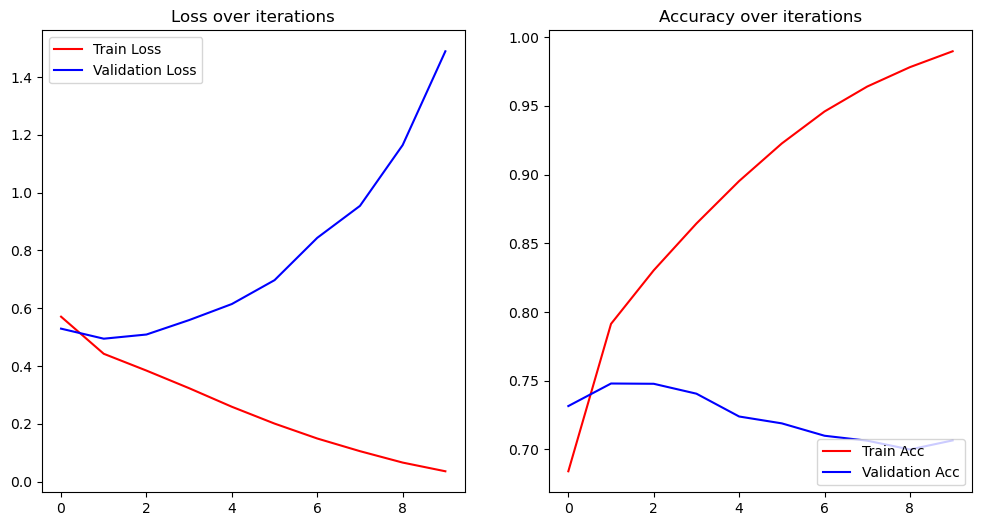

In [50]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=20))
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10,batch_size=30,validation_split=0.2)

display_metrics(history)

<details>
    <summary>Click here for Solution</summary>

```python
model = Sequential()
model.add(Embedding(10000, 8, input_length=20))
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10,batch_size=30,validation_split=0.2)

display_metrics(history)
```
</details>


### Exercise 2 - Question: Does this model perform better then the last model? Why or why not?


No, it suffers from overfitting

<details>
    <summary>Click here for Solution</summary>


The second model suffers from over Overfitting

</details>


### Exercise 3 - Introduce L2 and dropout regulation to your model (there are many solutions, one is given here)


In [ ]:
# Enter your solution here

model = Sequential()
model.add(Embedding(max_features, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(500, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.L2(l2=5e-3)))
model.add(Dropout(.4))

model.add(Dense(250, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.L2(l2=5e-3)))
model.add(Dropout(.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
model.summary()

history = model.fit(x_train, y_train, epochs=10,batch_size=64, validation_split=0.2)
display_metrics(history)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten_2 (Flatten)         (None, 160)               0         
                                                                 
 dense_4 (Dense)             (None, 500)               80500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_5 (Dense)             (None, 250)               125250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

<details>
    <summary>Click here for Solution</summary>

```python
model = Sequential()
model.add(Embedding(max_features, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(500, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.L2(l2=5e-3)))
model.add(Dropout(.4))

model.add(Dense(250, kernel_initializer='normal', activation='relu',kernel_regularizer=regularizers.L2(l2=5e-3)))
model.add(Dropout(.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) 
model.summary()

history = model.fit(x_train, y_train, epochs=10,batch_size=64, validation_split=0.2)
display_metrics(history)
```
</details>


## Congratulations! You have completed this lab!


## Author


[Joseph Santarcangelo](https://www.linkedin.com/in/david-pasternak-6b84a2208/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01)


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                 |
| ----------------- | ------- | ---------- | ---------------------------------- |
| 2022-03-28        | 0.1     | David Pasternak      | Created Lab    |
| 2022-05-10        | 0.2     | Sam Prokopchuk      | Complete Draft of Lab    |
| 2022-08-10        | 0.2     | Roxanne Li      | Review and edit Lab    |
| 2022-09-08        | 0.2     | Steve Hord      | QA pass and edits      |


## <h3 align="center"> © IBM Corporation 2022. All rights reserved. <h3/>
